In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

/home/ailab/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# get data
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

2023-01-13 00:43:22.103393: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 00:43:22.107628: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 00:43:22.107743: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 00:43:22.108045: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
# process data

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [4]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 4
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [5]:
# monitor
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

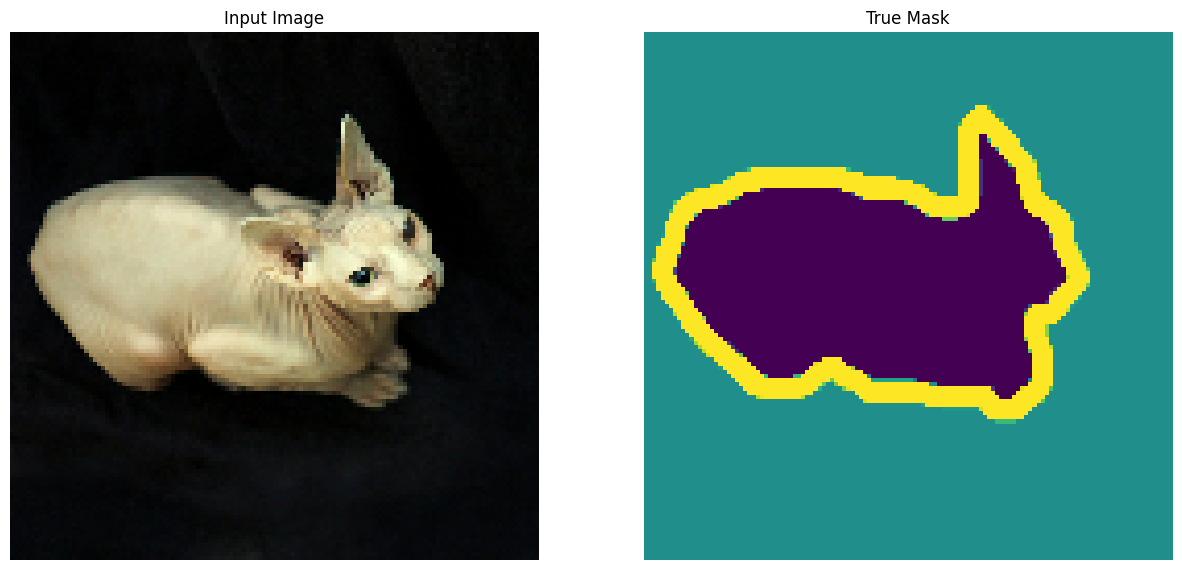

In [6]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
    display([sample_image, sample_mask])

In [7]:
model = tf.keras.Sequential()    

# block 1
model.add(tf.keras.layers.Conv2D(64, 9, padding='same', activation='LeakyReLU', input_shape=(128, 128, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D())

# block 2
model.add(tf.keras.layers.Conv2D(128, 9, padding='same', activation='LeakyReLU'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D())

# block 3
model.add(tf.keras.layers.Conv2D(256, 5, padding='same', activation='LeakyReLU'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D())

# block 4
model.add(tf.keras.layers.Conv2D(512, 5, padding='same', activation='LeakyReLU'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D())

# block 5
model.add(tf.keras.layers.Conv2D(512, 3, padding='same', activation='LeakyReLU'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D())

# block 5
model.add(tf.keras.layers.Conv2D(512, 3, padding='same', activation='LeakyReLU'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D())

# output 
model.add(tf.keras.layers.Conv2D(128*128*3, 2))
model.add(tf.keras.layers.Reshape((128,128,3)))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      15616     
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       663680    
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                                 
                                                        

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])
        
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):        
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/20


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
2023-01-13 00:43:33.001210: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2023-01-13 00:43:33.493737: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-13 00:43:33.494166: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-13 00:43:33.494181: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-01-13 00:43:33.494598: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-13 00:43:33.494638: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas loca

  6/920 [..............................] - ETA: 1:00 - loss: 1.0746 - accuracy: 0.5833WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0145s vs `on_train_batch_end` time: 0.0430s). Check your callbacks.


920/920 [==============================] - ETA: 0s - loss: 0.8433 - accuracy: 0.6697

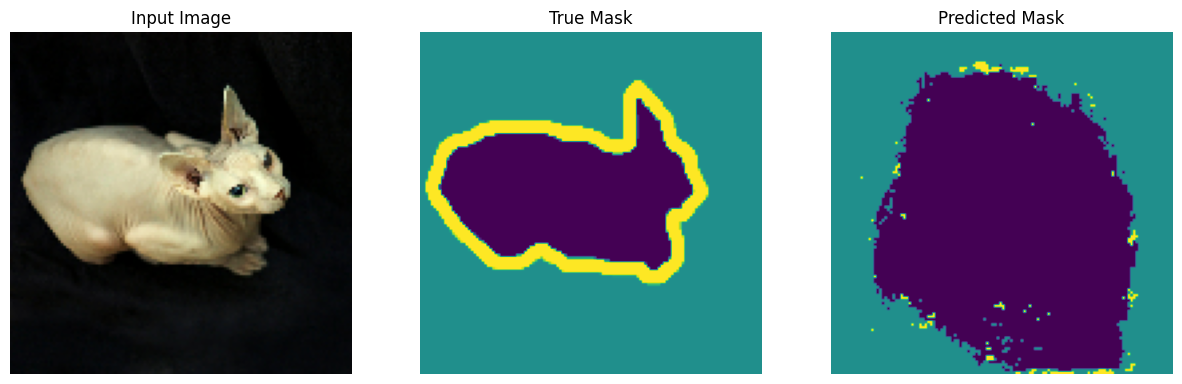


Sample Prediction after epoch 1

920/920 [==============================] - 61s 63ms/step - loss: 0.8433 - accuracy: 0.6697 - val_loss: 1.0418 - val_accuracy: 0.6296
Epoch 2/20
920/920 [==============================] - ETA: 0s - loss: 0.6968 - accuracy: 0.7170

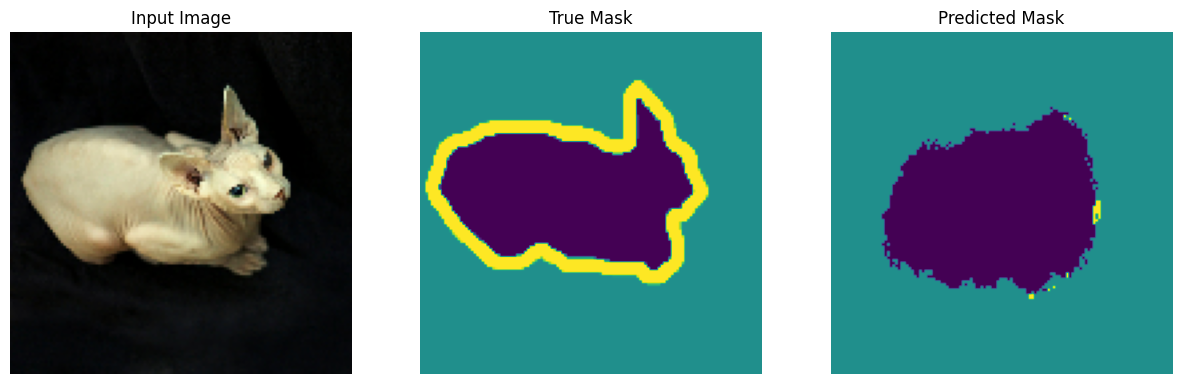


Sample Prediction after epoch 2

920/920 [==============================] - 58s 63ms/step - loss: 0.6968 - accuracy: 0.7170 - val_loss: 0.7022 - val_accuracy: 0.7114
Epoch 3/20
920/920 [==============================] - ETA: 0s - loss: 0.6409 - accuracy: 0.7382

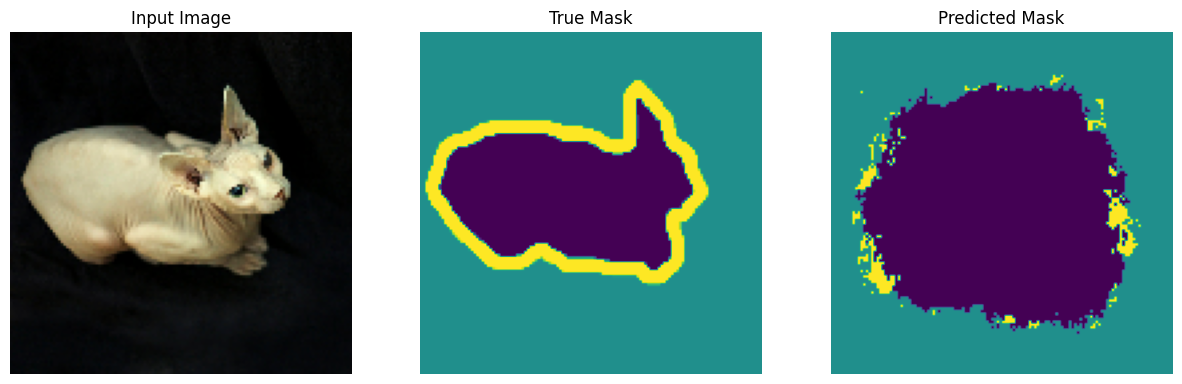


Sample Prediction after epoch 3

920/920 [==============================] - 58s 63ms/step - loss: 0.6409 - accuracy: 0.7382 - val_loss: 0.7606 - val_accuracy: 0.7070
Epoch 4/20
920/920 [==============================] - ETA: 0s - loss: 0.5951 - accuracy: 0.7544

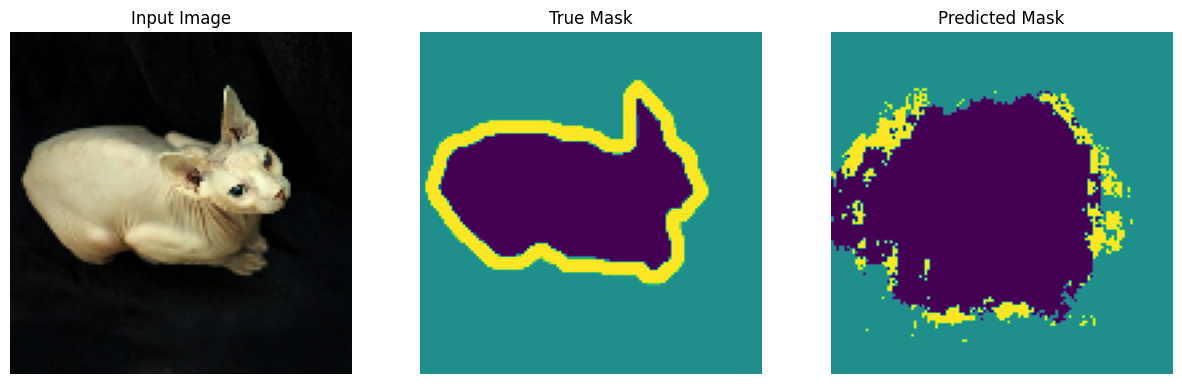


Sample Prediction after epoch 4

920/920 [==============================] - 58s 63ms/step - loss: 0.5951 - accuracy: 0.7544 - val_loss: 0.6136 - val_accuracy: 0.7516
Epoch 5/20
920/920 [==============================] - ETA: 0s - loss: 0.5444 - accuracy: 0.7736

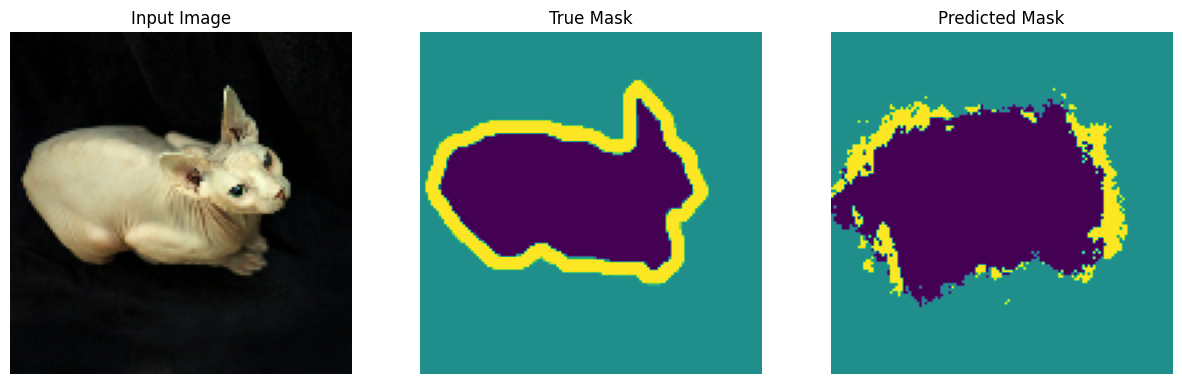


Sample Prediction after epoch 5

920/920 [==============================] - 58s 63ms/step - loss: 0.5444 - accuracy: 0.7736 - val_loss: 0.6248 - val_accuracy: 0.7492
Epoch 6/20
920/920 [==============================] - ETA: 0s - loss: 0.4935 - accuracy: 0.7937

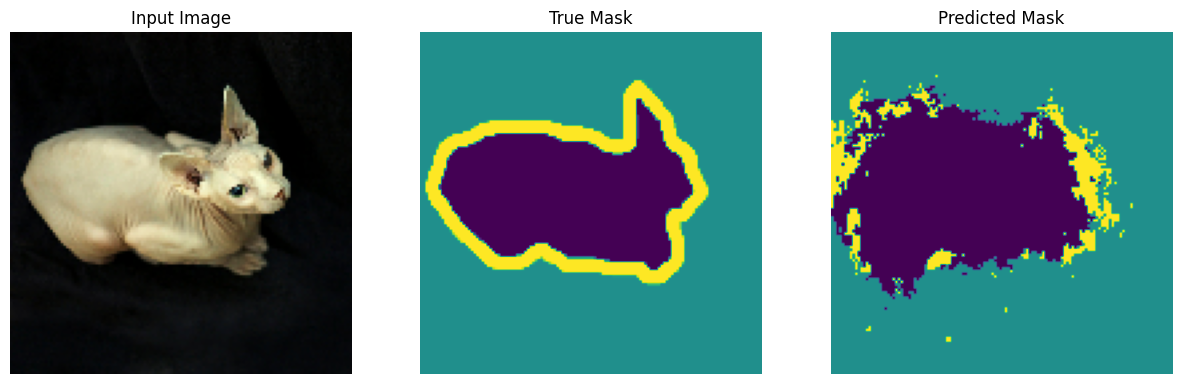


Sample Prediction after epoch 6

920/920 [==============================] - 58s 63ms/step - loss: 0.4935 - accuracy: 0.7937 - val_loss: 0.5930 - val_accuracy: 0.7600
Epoch 7/20
920/920 [==============================] - ETA: 0s - loss: 0.4378 - accuracy: 0.8156

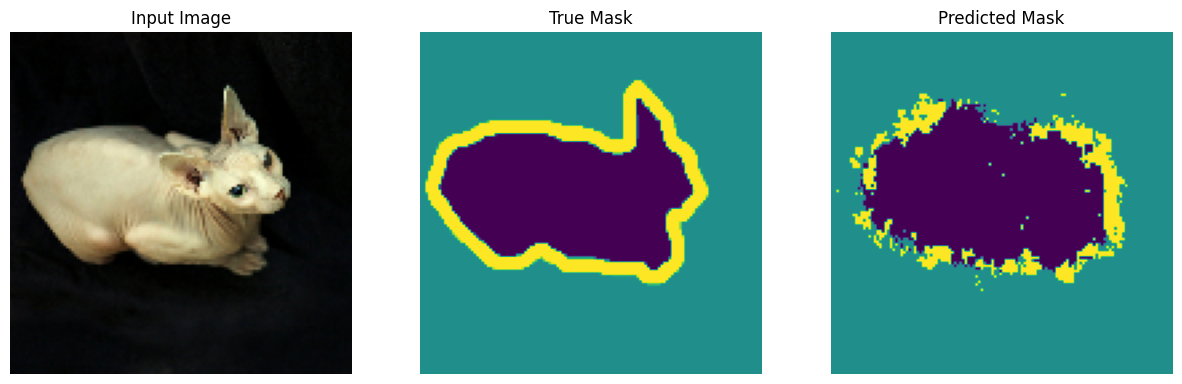


Sample Prediction after epoch 7

920/920 [==============================] - 58s 63ms/step - loss: 0.4378 - accuracy: 0.8156 - val_loss: 0.6064 - val_accuracy: 0.7608
Epoch 8/20
920/920 [==============================] - ETA: 0s - loss: 0.3724 - accuracy: 0.8417

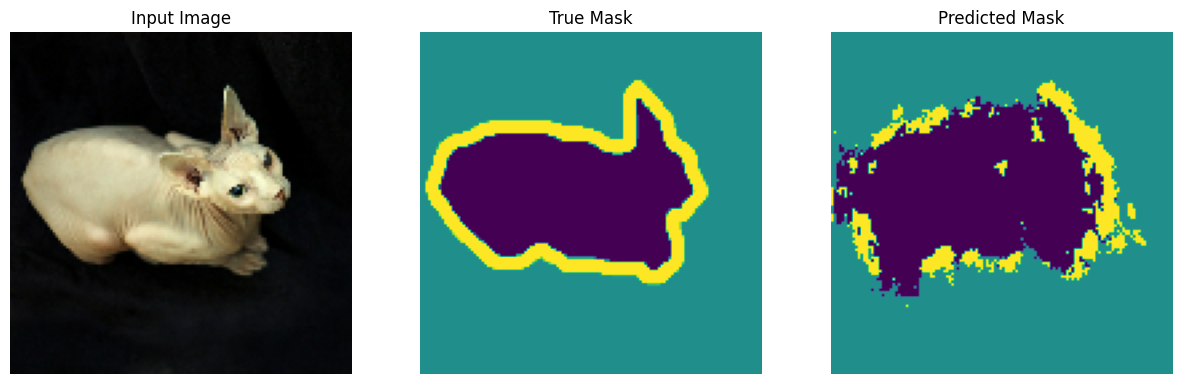


Sample Prediction after epoch 8

920/920 [==============================] - 58s 63ms/step - loss: 0.3724 - accuracy: 0.8417 - val_loss: 0.6162 - val_accuracy: 0.7596
Epoch 9/20
920/920 [==============================] - ETA: 0s - loss: 0.3068 - accuracy: 0.8682

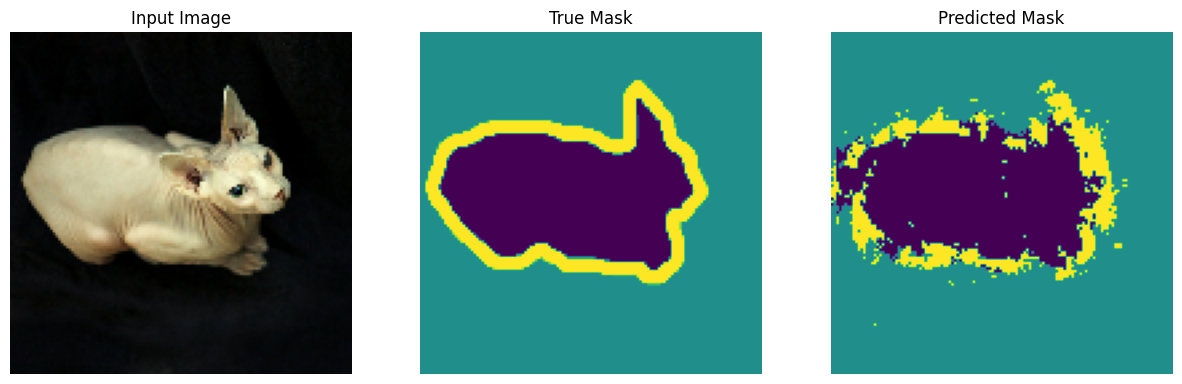


Sample Prediction after epoch 9

920/920 [==============================] - 58s 63ms/step - loss: 0.3068 - accuracy: 0.8682 - val_loss: 0.6723 - val_accuracy: 0.7605
Epoch 10/20
920/920 [==============================] - ETA: 0s - loss: 0.2515 - accuracy: 0.8902

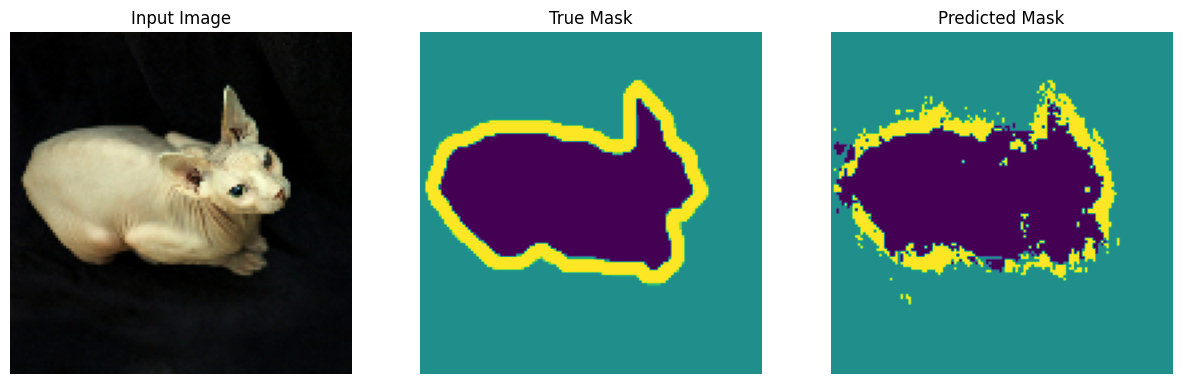


Sample Prediction after epoch 10

920/920 [==============================] - 58s 63ms/step - loss: 0.2515 - accuracy: 0.8902 - val_loss: 0.7219 - val_accuracy: 0.7645
Epoch 11/20
920/920 [==============================] - ETA: 0s - loss: 0.2034 - accuracy: 0.9089

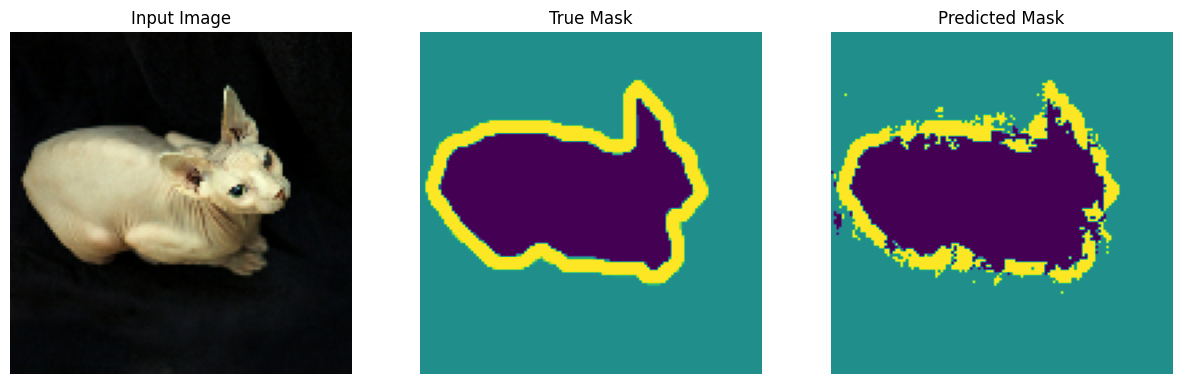


Sample Prediction after epoch 11

920/920 [==============================] - 58s 63ms/step - loss: 0.2034 - accuracy: 0.9089 - val_loss: 0.7470 - val_accuracy: 0.7578
Epoch 12/20
920/920 [==============================] - ETA: 0s - loss: 0.1661 - accuracy: 0.9233

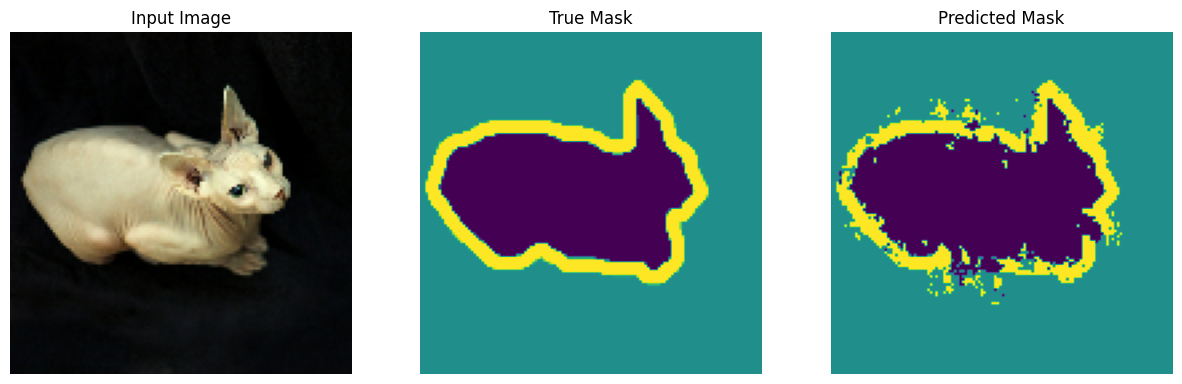


Sample Prediction after epoch 12

920/920 [==============================] - 58s 63ms/step - loss: 0.1661 - accuracy: 0.9233 - val_loss: 0.8564 - val_accuracy: 0.7573
Epoch 13/20
920/920 [==============================] - ETA: 0s - loss: 0.1347 - accuracy: 0.9351

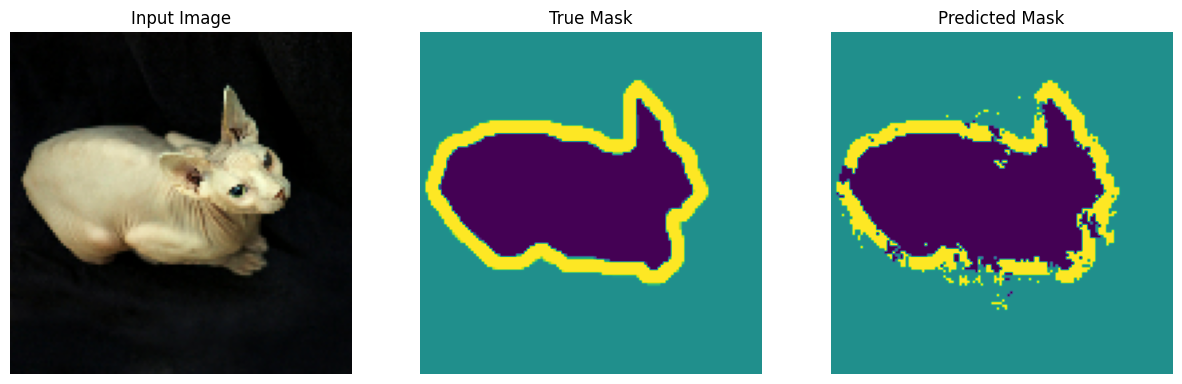


Sample Prediction after epoch 13

920/920 [==============================] - 58s 63ms/step - loss: 0.1347 - accuracy: 0.9351 - val_loss: 0.9271 - val_accuracy: 0.7560
Epoch 14/20
920/920 [==============================] - ETA: 0s - loss: 0.1094 - accuracy: 0.9445

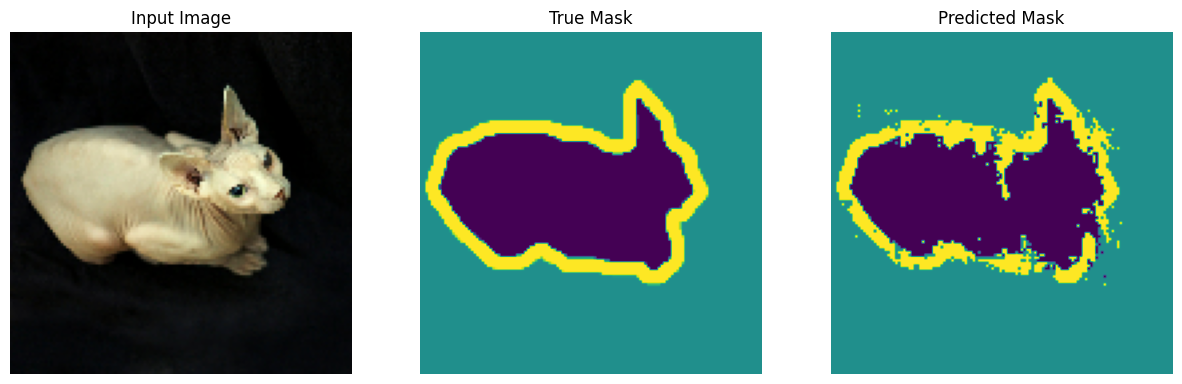


Sample Prediction after epoch 14

920/920 [==============================] - 57s 62ms/step - loss: 0.1094 - accuracy: 0.9445 - val_loss: 0.9893 - val_accuracy: 0.7530
Epoch 15/20
920/920 [==============================] - ETA: 0s - loss: 0.0894 - accuracy: 0.9517

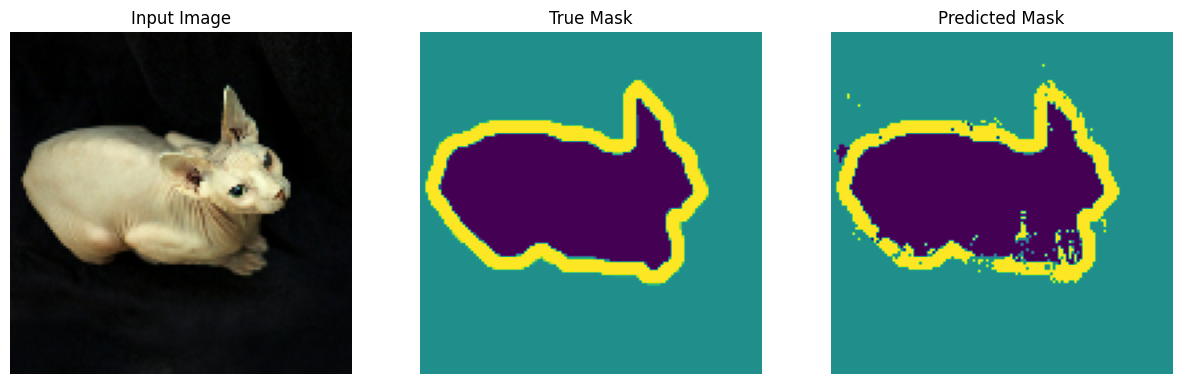


Sample Prediction after epoch 15

920/920 [==============================] - 55s 59ms/step - loss: 0.0894 - accuracy: 0.9517 - val_loss: 1.0734 - val_accuracy: 0.7516
Epoch 16/20
920/920 [==============================] - ETA: 0s - loss: 0.0742 - accuracy: 0.9571

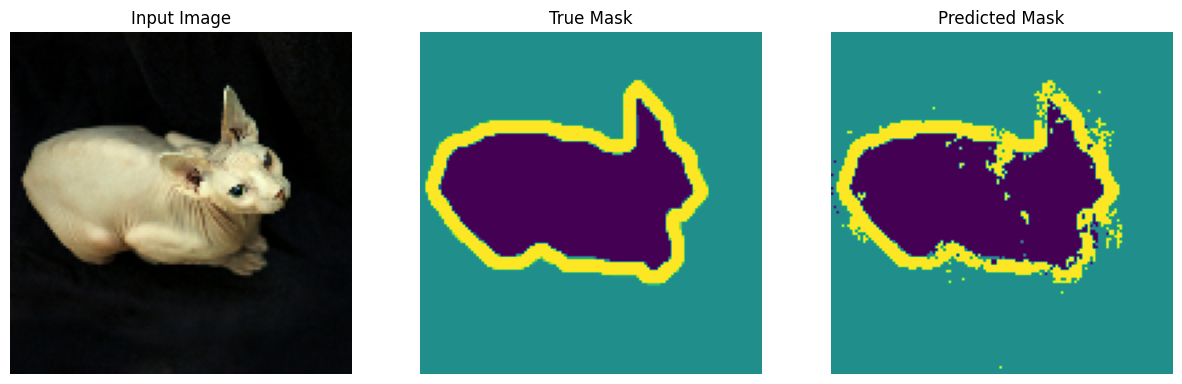


Sample Prediction after epoch 16

920/920 [==============================] - 54s 59ms/step - loss: 0.0742 - accuracy: 0.9571 - val_loss: 1.1612 - val_accuracy: 0.7515
Epoch 17/20
920/920 [==============================] - ETA: 0s - loss: 0.0616 - accuracy: 0.9614

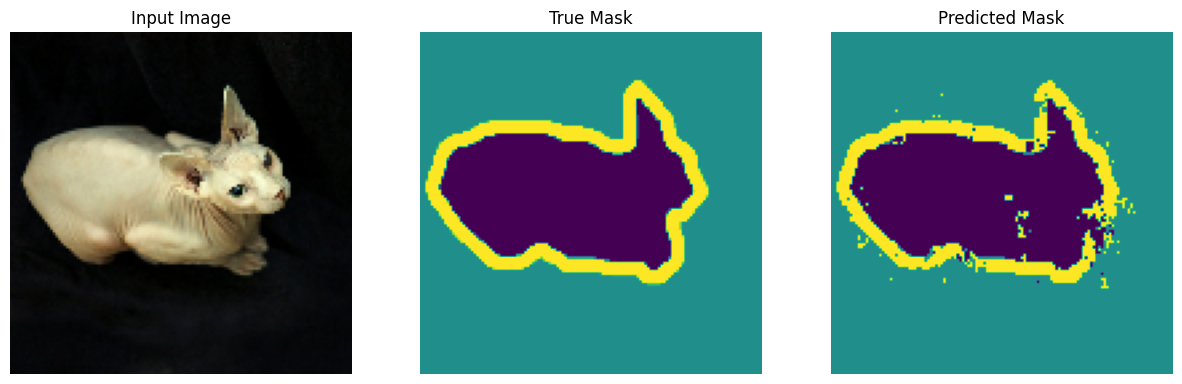


Sample Prediction after epoch 17

920/920 [==============================] - 55s 60ms/step - loss: 0.0616 - accuracy: 0.9614 - val_loss: 1.2538 - val_accuracy: 0.7512
Epoch 18/20
920/920 [==============================] - ETA: 0s - loss: 0.0523 - accuracy: 0.9646

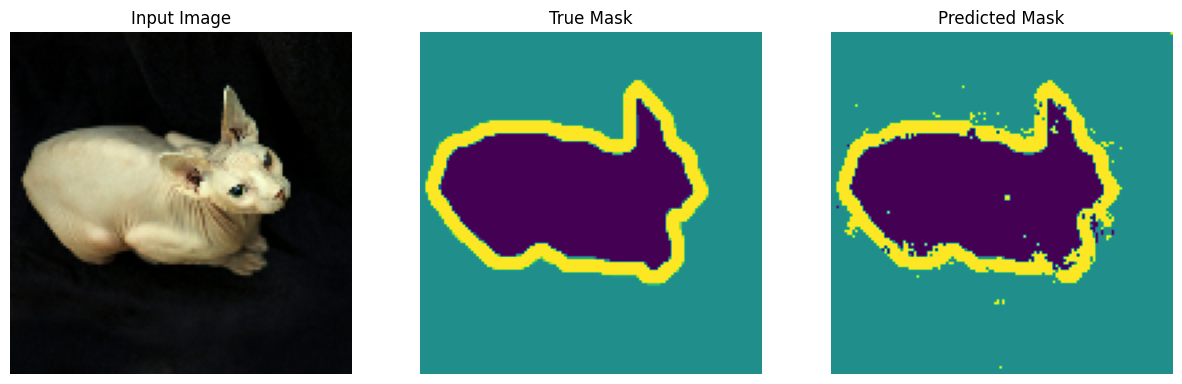


Sample Prediction after epoch 18

920/920 [==============================] - 55s 59ms/step - loss: 0.0523 - accuracy: 0.9646 - val_loss: 1.2934 - val_accuracy: 0.7493
Epoch 19/20
920/920 [==============================] - ETA: 0s - loss: 0.0463 - accuracy: 0.9666

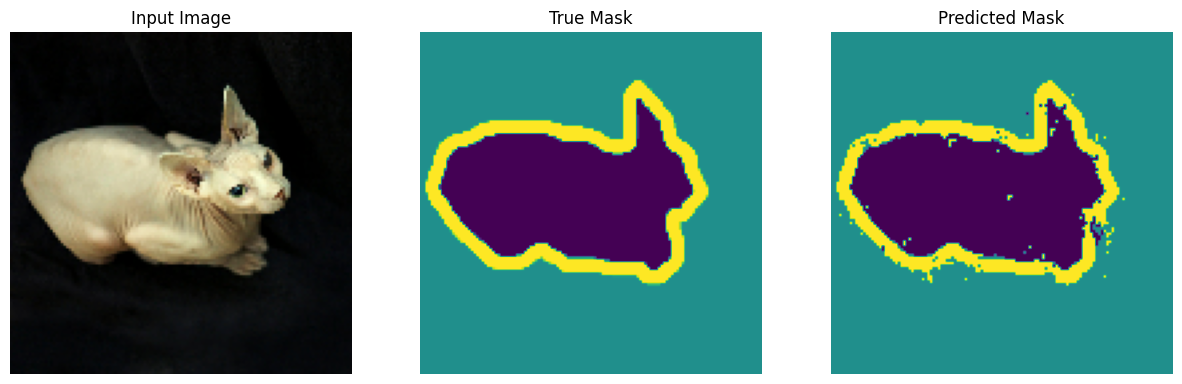


Sample Prediction after epoch 19

920/920 [==============================] - 55s 60ms/step - loss: 0.0463 - accuracy: 0.9666 - val_loss: 1.3731 - val_accuracy: 0.7509
Epoch 20/20
920/920 [==============================] - ETA: 0s - loss: 0.0405 - accuracy: 0.9686

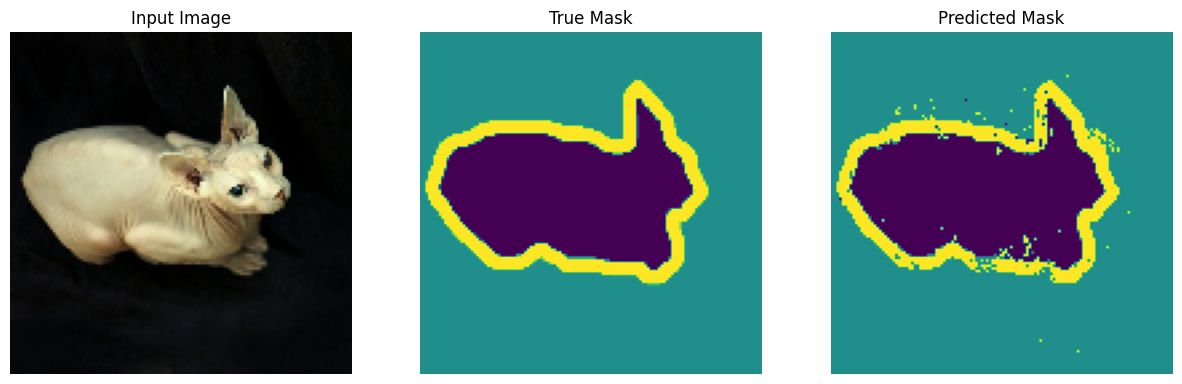


Sample Prediction after epoch 20

920/920 [==============================] - 55s 59ms/step - loss: 0.0405 - accuracy: 0.9686 - val_loss: 1.4757 - val_accuracy: 0.7487


In [9]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

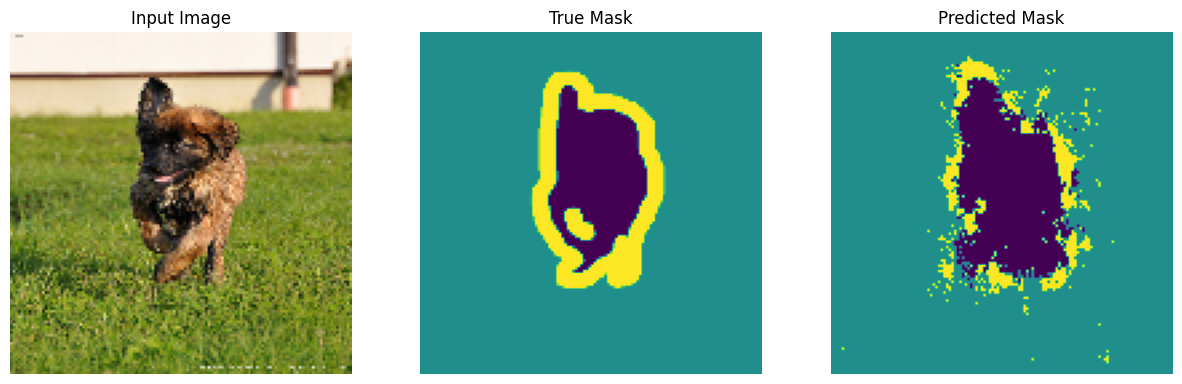

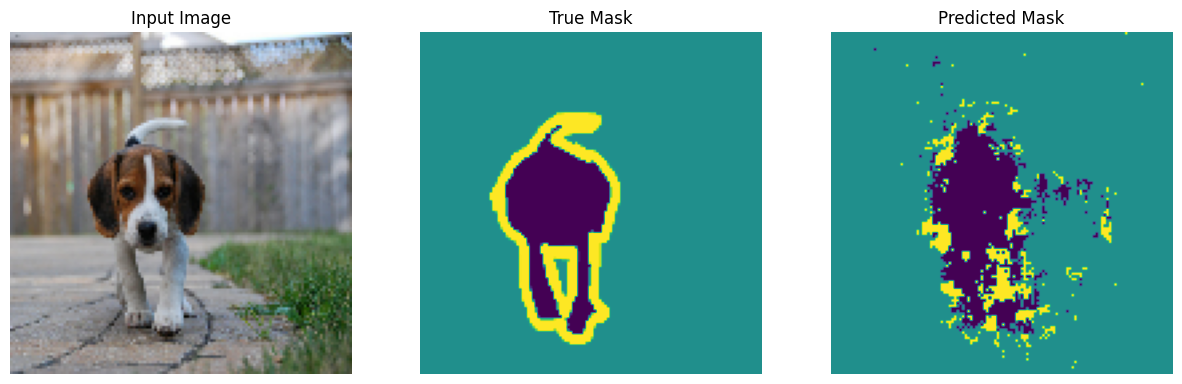

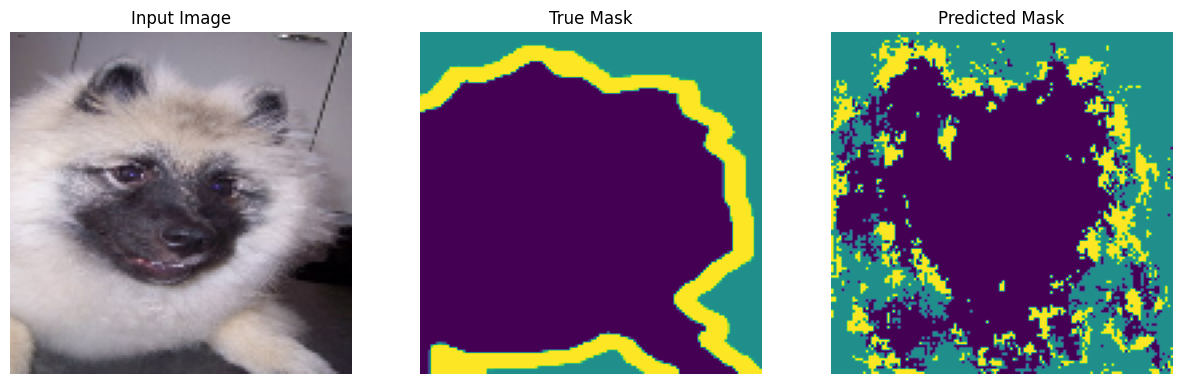

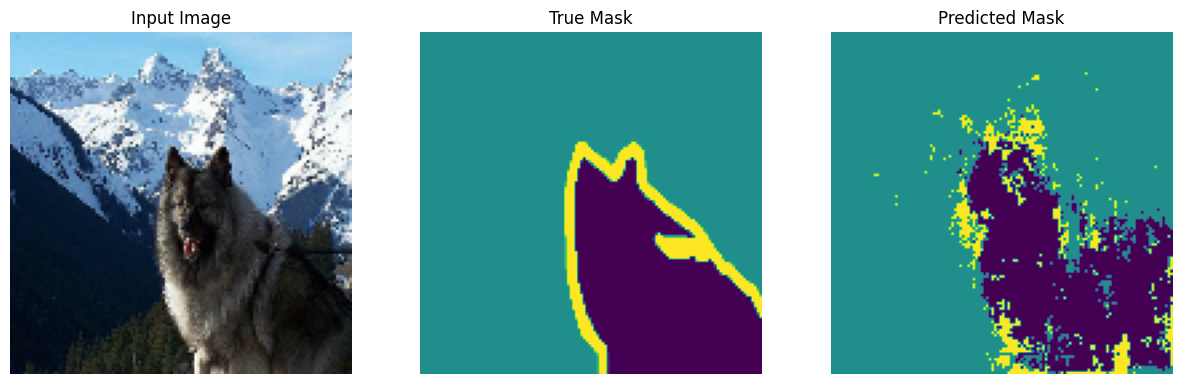

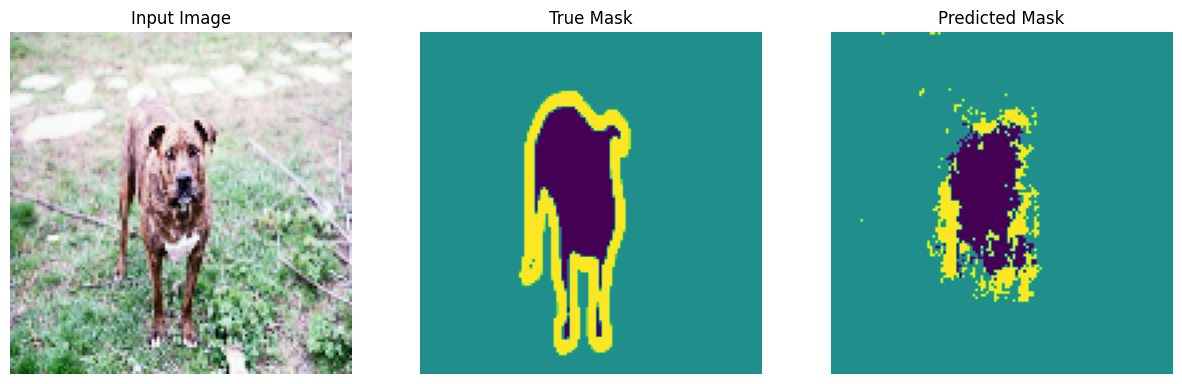

In [10]:
show_predictions(test_dataset, 5)